In [101]:
import os

USE_LOCAL_RUNTIME = True

if USE_LOCAL_RUNTIME:
#     os.chdir('/home/tom/Workspace/hypeminer/misc/optimisation')
    os.chdir('C:/Users/Agando/Workspace/hypeminer/misc/optimisation') 
else:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/hypeminer/training-data/optimisation')

In [102]:
import json
import pandas as pd
from datetime import datetime
from IPython.display import display
import requests

symbol = 'BNBUSDT'
start = '20210101000000' # '20200101000000' # 
freq = 5
days = 30 # 365 # 

# strategy = 'MACDDPeaks'
strategy = 'MACDDPnL'
# strategy = 'MACDVigano'

# ---------------------------------------------------------

FEES = 0.001

def to_datetime(timestamp):
    return datetime(
      int(timestamp[0:4]), int(timestamp[4:6]), int(timestamp[6:8]), 
      int(timestamp[8:10]), int(timestamp[10:12]), int(timestamp[12:14])
  )

def get_value(v):
    try:
        return float(v['value'])
    except:
        return float(v['value'][0][1])

def load_file(file):
    df = pd.DataFrame()
    with open(file) as f:
        data = json.load(f)
    df['ds'] = [datetime.strptime(v['timestamp'], '%Y-%m-%d %H:%M:%S') for v in data]
    df['open'] = [get_value(v) for v in data]
    return df

def display_whole(dframe):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(dframe)

strategies = {
    'MACDDPnL': "MACD Diff Peak&Limit",
    'MACDDPeaks': "MACD Diff Peaks",
    'MACDVigano': "MACD Viganò HistoCross"
}

run_id = f"{symbol}-{start}-{freq}-{days}-{strategy}"
run_title = f"{symbol} - {strategies[strategy]} at {days} days from " \
            f"{to_datetime(start).strftime('%Y-%m-%d')} every {freq} minutes"
file = f"{symbol}-{start}-{freq}-{days}.json"

to_interval = {
    1: '1m',
    3: '3m',
    5: '5m',
    15: '15m',
    30: '30m',
    60: '1h',
    120: '2h',
    240: '4h',
    360: '6h',
    480: '8h',
    720: '12h',
    1440: '1d',
    4320: '3d',
    10080: '1w',
}

def to_epoch(timestamp, milliseconds=True):
    dt = to_datetime(timestamp)
    epoch = dt.timestamp()
    if milliseconds:
        return int(epoch * 1000)
    else:
        return int(epoch)
    
def to_readable(epoch):
    return datetime.fromtimestamp(epoch/1000).strftime('%Y-%m-%d %H:%M:%S')

BINANCE_URL = "https://api.binance.com/api/v3/klines?symbol={}&interval={}&limit={}&startTime={}"

def fetch(symbol, epoch, interval="1m", limit=1):
    response = requests.request("GET", BINANCE_URL.format(symbol, interval, limit, epoch))
    result = json.loads(response.text)
    return result
    
def download_history_fast(symbol, start, delta_minutes=60, days=90):
    millis_in_period = days * 24 * 60 * 60 * 1000
    file_dest = f"{symbol}-{start}-{delta_minutes}-{days}.json"
    if os.path.isfile(file_dest):
        return
    epoch = to_epoch(start)
    epoch_at_start = epoch
    interval = to_interval[delta_minutes]
    values = []
    i = 0
    completed = False
    while not completed:
        values_batch = fetch(symbol, epoch, interval=interval, limit=1000)
        for value in values_batch:
            obj = {"index": i, "timestamp": to_readable(value[0]), "value": value[1]}
            values.append(obj)
            i += 1
            if value[0] >= epoch_at_start + millis_in_period:
                completed = True
                break
        print(f"Fetched {len(values)} values at {to_readable(epoch)}...")
        epoch += 1000 * delta_minutes * 60000

    with open(file_dest, 'w') as f_out:
        json.dump(values, f_out)

download_history_fast(symbol, start, delta_minutes=freq, days=days)

Fetched 1000 values at 2021-01-01 00:00:00...
Fetched 2000 values at 2021-01-04 11:20:00...
Fetched 3000 values at 2021-01-07 22:40:00...
Fetched 4000 values at 2021-01-11 10:00:00...
Fetched 5000 values at 2021-01-14 21:20:00...
Fetched 6000 values at 2021-01-18 08:40:00...
Fetched 7000 values at 2021-01-21 20:00:00...
Fetched 8000 values at 2021-01-25 07:20:00...
Fetched 8641 values at 2021-01-28 18:40:00...


In [103]:
df_orig = load_file(file)
df_orig

,ds,open
0,2021-01-01 00:00:00,37.3596
1,2021-01-01 00:05:00,37.2596
2,2021-01-01 00:10:00,37.1082
3,2021-01-01 00:15:00,37.0134
4,2021-01-01 00:20:00,37.1186
...,...,...
8636,2021-01-30 23:40:00,44.7789
8637,2021-01-30 23:45:00,44.7640
8638,2021-01-30 23:50:00,44.7256
8639,2021-01-30 23:55:00,44.8073


In [105]:
# exponential moving average
def ema(data, n):
    alpha = 2 / (1 + n)
    return data.ewm(alpha=alpha, adjust=False).mean()

df_orig['ema12'] = ema(df_orig['open'], 12)
df_orig['ema26'] = ema(df_orig['open'], 26)
df_orig['macd'] = df_orig['ema12'] - df_orig['ema26']
df_orig['signal'] = ema(df_orig['macd'], 9)
df_orig['macddiff'] = df_orig['macd'] - df_orig['signal']
# df_orig['macddiff'] = 1000 * (df_orig['macd'] - df_orig['signal']) / df_orig['open']

df_orig

,ds,open,ema12,ema26,macd,signal,macddiff
0,2021-01-01 00:00:00,37.3596,37.359600,37.359600,0.000000,0.000000,0.000000
1,2021-01-01 00:05:00,37.2596,37.344215,37.352193,-0.007977,-0.001595,-0.006382
2,2021-01-01 00:10:00,37.1082,37.307905,37.334119,-0.026214,-0.006519,-0.019695
3,2021-01-01 00:15:00,37.0134,37.262597,37.310362,-0.047765,-0.014768,-0.032997
4,2021-01-01 00:20:00,37.1186,37.240443,37.296157,-0.055714,-0.022957,-0.032757
...,...,...,...,...,...,...,...
8636,2021-01-30 23:40:00,44.7789,44.814794,44.817615,-0.002820,0.018729,-0.021549
8637,2021-01-30 23:45:00,44.7640,44.806980,44.813643,-0.006663,0.013650,-0.020314
8638,2021-01-30 23:50:00,44.7256,44.794460,44.807121,-0.012662,0.008388,-0.021050
8639,2021-01-30 23:55:00,44.8073,44.796435,44.807135,-0.010699,0.004571,-0.015270


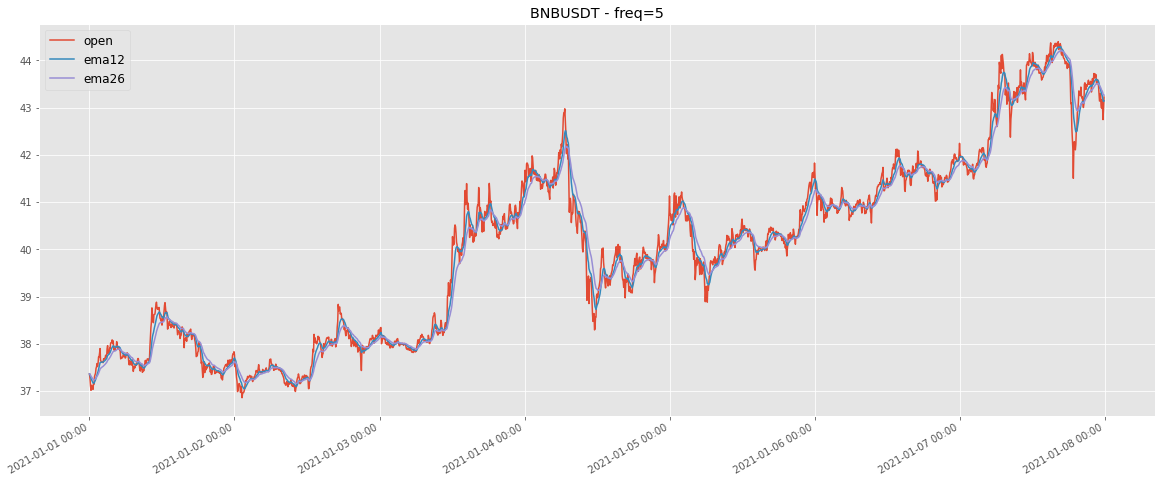

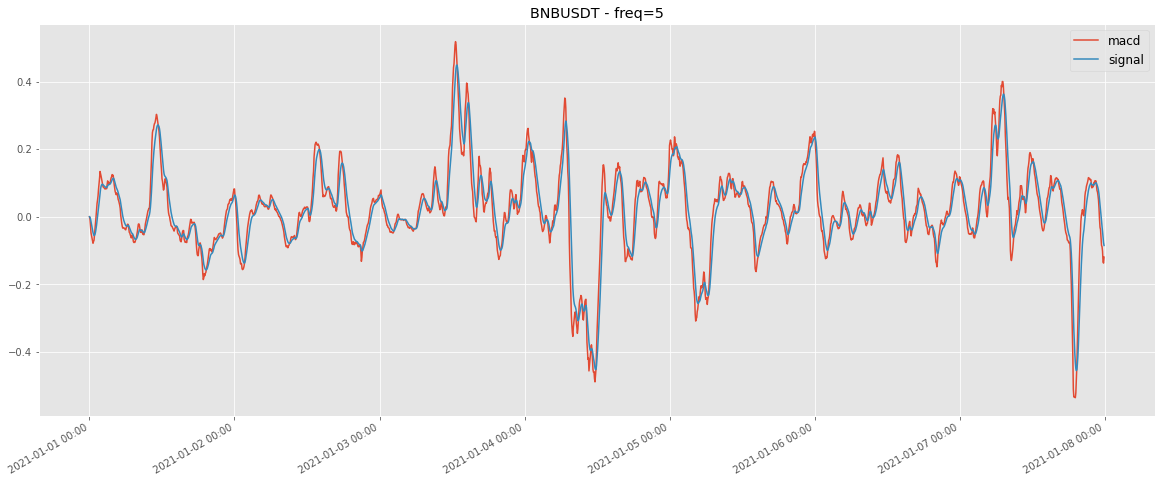

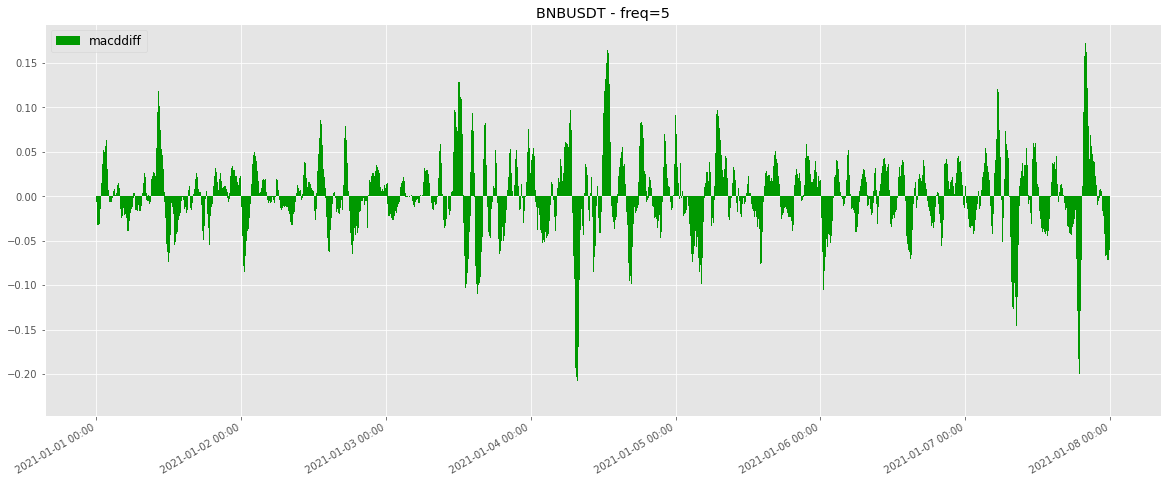

In [106]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('ggplot')

def plot(typ, df_plot, cols, title=None, baseline=None):
    plt.rcParams["figure.figsize"] = (20, 8)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    for col in cols:
        if typ == 'line':
            plt.plot(df_plot['ds'], df_plot[col], label=col)
        elif typ == 'bars':
            plt.bar(df_plot['ds'], df_plot[col], color='#009900', label=col, width=.005)
    if baseline:
        try:
            for bl in baseline:
                plt.axhline(y=bl, color='b', linestyle='-', label='baseline')
        except:
            plt.axhline(y=baseline, color='b', linestyle='-', label='baseline')
    plt.legend(loc="best", prop={'size': 12})
    if not title:
        title = f"{symbol} - freq={freq}"
    plt.title(title)
    plt.gcf().autofmt_xdate()
    plt.show()

samples = int(7 * 24 * 60 / 5)
dfs = df_orig.iloc[:samples]

plot('line', dfs, ['open', 'ema12', 'ema26'])
plot('line', dfs, ['macd', 'signal'])
plot('bars', dfs, ['macddiff'])

In [107]:
df_orig['prev_open'] = df_orig['open'].shift(1)

df_orig['is_negative'] = df_orig['macddiff'] < 0
df_orig['is_upward'] = df_orig['macddiff'].diff() > 0

df_orig.iloc[:30]

,ds,open,ema12,ema26,macd,signal,macddiff,prev_open,is_negative,is_upward
0,2021-01-01 00:00:00,37.3596,37.359600,37.359600,0.000000,0.000000,0.000000,NaN,False,False
1,2021-01-01 00:05:00,37.2596,37.344215,37.352193,-0.007977,-0.001595,-0.006382,37.3596,True,False
2,2021-01-01 00:10:00,37.1082,37.307905,37.334119,-0.026214,-0.006519,-0.019695,37.2596,True,False
3,2021-01-01 00:15:00,37.0134,37.262597,37.310362,-0.047765,-0.014768,-0.032997,37.1082,True,False
4,2021-01-01 00:20:00,37.1186,37.240443,37.296157,-0.055714,-0.022957,-0.032757,37.0134,True,True
5,2021-01-01 00:25:00,37.0935,37.217837,37.281146,-0.063309,-0.031028,-0.032281,37.1186,True,True
6,2021-01-01 00:30:00,37.0653,37.194370,37.265157,-0.070788,-0.038980,-0.031808,37.0935,True,True
7,2021-01-01 00:35:00,37.0325,37.169467,37.247923,-0.078457,-0.046875,-0.031582,37.0653,True,True
8,2021-01-01 00:40:00,37.1644,37.168687,37.241736,-0.073049,-0.052110,-0.020939,37.0325,True,True
9,2021-01-01 00:45:00,37.1433,37.164781,37.234445,-0.069663,-0.055621,-0.014043,37.1644,True,True


In [108]:
def compute_macd_vigano_histocross(df_orig, verbose=False, plot_chart=False):
    
    df = df_orig.copy()

    df['prev_is_negative'] = df['is_negative'].shift(1)
    
    df['suggest'] = 'IDLE'
    df.loc[(df['is_negative'] == False) & (df['prev_is_negative'] == True), 'suggest'] = 'BUY'
    df.loc[(df['is_negative'] == True) & (df['prev_is_negative'] == False), 'suggest'] = 'SELL'

    s = 'OUT' # IN=invested, OUT=liquidated
    assets = 1

    assets_values = []
    actions = []
    investment = None
    for index, row in df.iterrows():
        if s == 'IN': # this depends on the previous state
            assets = assets / row['prev_open'] * row['open']
        if s == 'OUT' and row['suggest'] == 'BUY':
            s = 'IN'
            actions.append('BUY')
            assets = assets * (1 - FEES)
            investment = assets
        elif s == 'IN' and row['suggest'] == 'SELL' and assets * (1-FEES) > investment:
            s = 'OUT'
            actions.append('SELL')
            assets = assets * (1 - FEES)
        else:
            actions.append('----')
        assets_values.append(assets)

    df['assets'] = assets_values
    df['action'] = actions
    bnh = df['open'].iloc[-1] / df['open'].iloc[0]
    
    if verbose:
        display_whole(df[:100])
    
    if plot_chart:
        df['buy-and-hold'] = df['open'] / df['open'].iloc[0]
        plot('line', df, ['assets', 'buy-and-hold'], title=f"{symbol} - {strategies[strategy]}")
    
    return assets, bnh    


if strategy == 'MACDVigano':
    compute_macd_vigano_histocross(df_orig, verbose=True, plot_chart=True)

In [109]:
def compute_macd_diff_peaks(df_orig, thr, verbose=False, plot_chart=False):
    
    df = df_orig.copy()

    df['suggest'] = 'IDLE'
    df.loc[df['is_negative'] & df['is_upward'], 'suggest'] = 'BUY'
    df.loc[(df['is_negative'] == False) & (df['is_upward'] == False), 'suggest'] = 'SELL'

    s = 'OUT' # IN=invested, OUT=liquidated
    assets = 1

    assets_values = []
    actions = []
    investment = None
    for index, row in df.iterrows():
        if s == 'IN': # this depends on the previous state
            assets = assets / row['prev_open'] * row['open']
        if s == 'OUT' and row['suggest'] == 'BUY' and row['macddiff'] < -thr:
            s = 'IN'
            actions.append('BUY')
            assets = assets * (1 - FEES)
            investment = assets
        elif s == 'IN' and row['suggest'] == 'SELL' and row['macddiff'] > thr and assets * (1-FEES) > investment:
            s = 'OUT'
            actions.append('SELL')
            assets = assets * (1 - FEES)
        else:
            actions.append('----')
        assets_values.append(assets)

    df['assets'] = assets_values
    df['action'] = actions
    bnh = df['open'].iloc[-1] / df['open'].iloc[0]
    
    if verbose:
        display_whole(df[:100])
    
    if plot_chart:
        df['buy-and-hold'] = df['open'] / df['open'].iloc[0]
        plot('line', df, ['assets', 'buy-and-hold'], title=f"{symbol} - {strategies[strategy]}")
    
    return assets, bnh    


if strategy == 'MACDDPeaks':
    results = {}
    for i in range(0, 11):
        thr = i / 10
        assets, bnh = compute_macd_diff_peaks(df_orig, thr)
        print((thr, assets))
        results[thr] = assets
    best_thr = sorted(results.items(), key=lambda x: x[1], reverse=True)[0][0]
    print(f"Best threshold: {best_thr}")
    compute_macd_diff_peaks(df_orig, best_thr, verbose=True, plot_chart=True)

In [112]:
def compute_macd_diff_peak_and_limit(df_orig, target, stop_loss, verbose=False, plot_chart=False):
    
    df = df_orig.copy()

    df['suggest'] = 'IDLE'
    df.loc[df['is_negative'] & df['is_upward'], 'suggest'] = 'BUY'

    df['limit'] = 0
    df.loc[df['suggest'] == 'BUY', 'limit'] = df['open'] * target

    df['stop'] = 0
    df.loc[df['suggest'] == 'BUY', 'stop'] = df['open'] * stop_loss

    s = 'OUT' # IN=invested, OUT=liquidated
    assets = 1
    limit = None
    stop = None

    assets_values = []
    actions = []
    results = []
    invest = []
    investment = None
    investment_when = None
    invest_when = []
    for index, row in df.iterrows():
        if s == 'IN': # this depends on the previous state
            assets = assets / row['prev_open'] * row['open']
        if s == 'OUT' and row['suggest'] == 'BUY':
            s = 'IN'
            limit = row['limit']
            stop = row['stop']
            actions.append('BUY')
            assets = assets * (1 - FEES)
            investment = assets
            investment_when = row['ds']
            results.append(np.nan)
            invest.append(np.nan)
            invest_when.append(np.nan)
        elif s == 'IN' and (row['open'] * (1-FEES) - limit >= 0 or row['open'] <= stop):
            s = 'OUT'
            limit = None
            stop = None
            actions.append('SELL')
            assets = assets * (1 - FEES)
            results.append('GAIN' if assets >= investment else 'LOSS')
            invest.append(investment)
            invest_when.append(investment_when)
        else:
            actions.append('----')
            results.append(np.nan)
            invest.append(np.nan)
            invest_when.append(np.nan)
        assets_values.append(assets)

    df['assets'] = assets_values
    df['action'] = actions
    df['result'] = results
    df['invest'] = invest
    df['invest-when'] = invest_when
    bnh = df['open'].iloc[-1] / df['open'].iloc[0]
    
    if verbose:
        display(df[:30])
    
    if plot_chart:
        df['buy-and-hold'] = df['open'] / df['open'].iloc[0]
        plot('line', df, ['assets', 'buy-and-hold'], title=f"{symbol} - {strategies[strategy]} target={target} stop_loss={stop_loss}")
    
    return assets, bnh, df

In [114]:
import numpy as np
import matplotlib.colors as colors

LIMIT_RANGE = [101, 111, 1]
STOP_LOSS_RANGE = [80, 99, 2]


class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

def build_heatmap(heat, file_id, xs, ys):
    info = file_id.split('-')

    X, Y = np.meshgrid(xs, ys)
    Z = np.array(heat['stake']).reshape(X.shape)
    bnh = heat['baseline'].iloc[-1]

    # heatmap
    plt.rcParams["figure.figsize"] = (20, 12)
    plt.xticks(range(len(xs)), [f"+{(x-1)*100:.0f}%" for x in xs])
    plt.yticks(range(len(ys)), [f"-{(1-y)*100:.0f}%" for y in ys])
    plt.grid(False)
    plt.title(run_title)
    plt.xlabel('target')
    plt.ylabel('stop_loss')
    heat = plt.imshow(Z, cmap='RdBu', norm=MidpointNormalize(midpoint=bnh))
    plt.colorbar(heat)
    if not os.path.exists(f"plots/{info[4]}"):
        os.makedirs(f"plots/{info[4]}")
    plt.savefig(f"plots/{info[4]}/{file_id}.png")
    plt.show()

def optimise(df_opt, run_id):
    
    # limit
    # xs = np.arange(101, 121, 1) / 100
    xs = np.arange(LIMIT_RANGE[0], LIMIT_RANGE[1]+1, LIMIT_RANGE[2]) / 100
    # stop_loss
    # ys = np.arange(80, 100, 1) / 100
    ys = np.arange(STOP_LOSS_RANGE[0], STOP_LOSS_RANGE[1]+1, STOP_LOSS_RANGE[2]) / 100

    tsv_file = f"{run_id}.tsv"

    if not os.path.isfile(tsv_file):
        heat = pd.DataFrame()
        targets, stop_losses, baselines, stakes = [], [], [], []
        for stop_loss in ys:
            for target in xs:
                stake, baseline, _ = compute_macd_diff_peak_and_limit(df_opt, target, stop_loss)
                print("\t".join(["{:.2f}".format(x) for x in [target, stop_loss, baseline, stake]]).expandtabs(8))
                targets.append(target)
                stop_losses.append(stop_loss)
                baselines.append(baseline)
                stakes.append(stake)
        heat['target'] = targets
        heat['stop_loss'] = stop_losses
        heat['baseline'] = baselines
        heat['stake'] = stakes
        heat.to_csv(tsv_file, sep='\t', index=False)
    else:
        heat = pd.read_csv(tsv_file, sep='\t')
    
    return heat, xs, ys


# if strategy == 'MACDDPnL':
#     heat, xs, ys = optimise(df_orig, run_id)    
#     display_whole(heat)
    
#     build_heatmap(heat, run_id, xs, ys)
    
#     best_target, best_stop_loss, _, _, = heat.sort_values(by='stake', ascending=False).iloc[0]

#     _, _, df_strategy = compute_macd_diff_peak_and_limit(
#         df_orig, best_target, best_stop_loss, verbose=False, plot_chart=True)

In [97]:
df_strategy['result-perc'] = (df_strategy['assets'] / df_strategy['invest'] - 1) * 100

display_whole(df_strategy[(df_strategy['result'] == 'GAIN') | (df_strategy['result'] == 'LOSS')])

,ds,open,ema12,ema26,macd,signal,macddiff,prev_open,is_negative,is_upward,suggest,limit,stop,assets,action,result,invest,invest-when,buy-and-hold,result-perc
720,2021-01-03 12:00:00,39.8531,39.151697,38.836645,0.315052,0.220854,2.363646,39.3961,False,True,IDLE,0.000000,0.000000,1.071523,SELL,GAIN,0.999000,2021-01-01 00:20:00,1.066743,7.259560
942,2021-01-04 06:30:00,42.8857,42.280261,41.977886,0.302375,0.206497,2.235673,42.7776,False,True,IDLE,0.000000,0.000000,1.147800,SELL,GAIN,1.070451,2021-01-03 13:20:00,1.147916,7.225788
1811,2021-01-07 06:55:00,44.1063,43.521451,43.133064,0.388387,0.318879,1.575927,43.7291,False,True,IDLE,0.000000,0.000000,1.229917,SELL,GAIN,1.146652,2021-01-04 07:35:00,1.180588,7.261567
3051,2021-01-11 14:15:00,36.1699,37.588495,38.094413,-0.505919,-0.338767,-4.621295,37.0116,True,False,IDLE,0.000000,0.000000,1.020097,SELL,LOSS,1.228687,2021-01-07 08:05:00,0.968155,-16.976706
3263,2021-01-12 07:55:00,39.8933,39.468381,39.290503,0.177878,0.161876,0.401119,39.7323,False,True,IDLE,0.000000,0.000000,1.092021,SELL,GAIN,1.019077,2021-01-11 14:20:00,1.067819,7.157875
4038,2021-01-15 00:30:00,42.1475,41.813641,41.563255,0.250386,0.211018,0.934053,41.9390,False,True,IDLE,0.000000,0.000000,1.169797,SELL,GAIN,1.090929,2021-01-12 08:30:00,1.128157,7.229433
4841,2021-01-17 19:25:00,45.2887,44.730639,44.474711,0.255929,0.180322,1.669428,45.0782,False,True,IDLE,0.000000,0.000000,1.252426,SELL,GAIN,1.168627,2021-01-15 01:15:00,1.212237,7.170734
5905,2021-01-21 12:05:00,39.5266,39.942476,40.131963,-0.189487,-0.177346,-0.307159,39.7211,True,False,IDLE,0.000000,0.000000,1.060254,SELL,LOSS,1.251174,2021-01-17 21:15:00,1.058004,-15.259245
6917,2021-01-25 00:25:00,42.4587,41.977001,41.772998,0.204004,0.154976,1.154704,42.1382,False,True,IDLE,0.000000,0.000000,1.134905,SELL,GAIN,1.059194,2021-01-21 12:20:00,1.136487,7.147978
8649,2021-01-31 00:45:00,45.3298,44.922251,44.869050,0.053202,0.015690,0.827533,44.9843,False,True,IDLE,0.000000,0.000000,1.213272,SELL,GAIN,1.133770,2021-01-25 01:30:00,1.213337,7.012225


1.01    0.80    1.05    1.05
1.02    0.80    1.05    1.05
1.03    0.80    1.05    1.06
1.04    0.80    1.05    1.05
1.05    0.80    1.05    1.06
1.06    0.80    1.05    1.06
1.07    0.80    1.05    1.06
1.08    0.80    1.05    1.06
1.09    0.80    1.05    1.06
1.10    0.80    1.05    1.06
1.11    0.80    1.05    1.06
1.01    0.82    1.05    1.05
1.02    0.82    1.05    1.05
1.03    0.82    1.05    1.06
1.04    0.82    1.05    1.05
1.05    0.82    1.05    1.06
1.06    0.82    1.05    1.06
1.07    0.82    1.05    1.06
1.08    0.82    1.05    1.06
1.09    0.82    1.05    1.06
1.10    0.82    1.05    1.06
1.11    0.82    1.05    1.06
1.01    0.84    1.05    1.05
1.02    0.84    1.05    1.05
1.03    0.84    1.05    1.06
1.04    0.84    1.05    1.05
1.05    0.84    1.05    1.06
1.06    0.84    1.05    1.06
1.07    0.84    1.05    1.06
1.08    0.84    1.05    1.06
1.09    0.84    1.05    1.06
1.10    0.84    1.05    1.06
1.11    0.84    1.05    1.06
1.01    0.86    1.05    1.05
1.02    0.86  

,target,stop_loss,baseline,stake
0,1.01,0.80,1.051676,1.054212
1,1.02,0.80,1.051676,1.053177
2,1.03,0.80,1.051676,1.063484
3,1.04,0.80,1.051676,1.051922
4,1.05,0.80,1.051676,1.059594
5,1.06,0.80,1.051676,1.061840
6,1.07,0.80,1.051676,1.056003
7,1.08,0.80,1.051676,1.056003
8,1.09,0.80,1.051676,1.056003
9,1.10,0.80,1.051676,1.056003


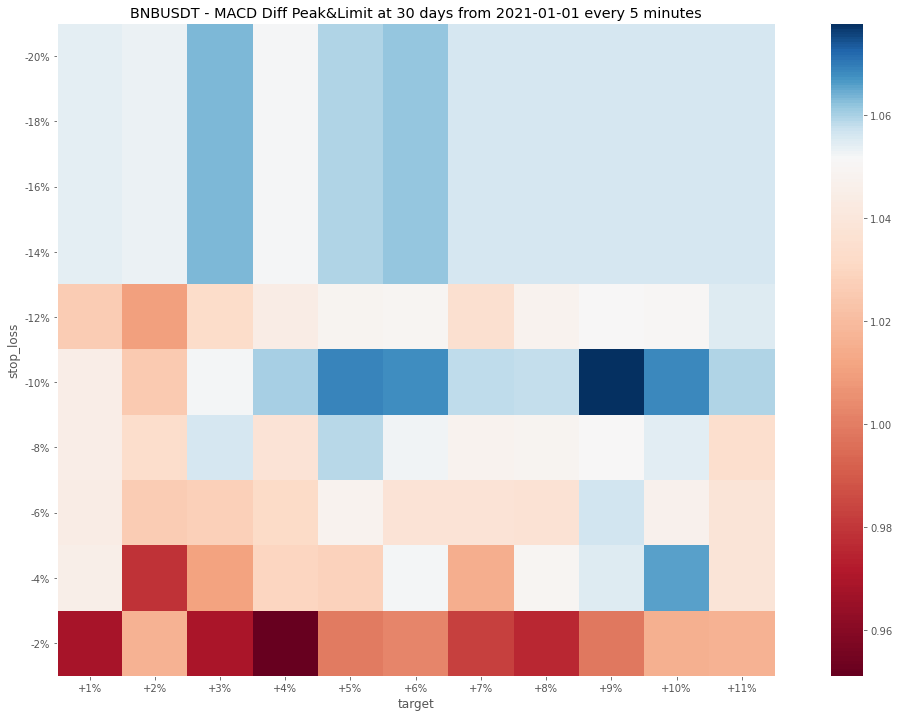

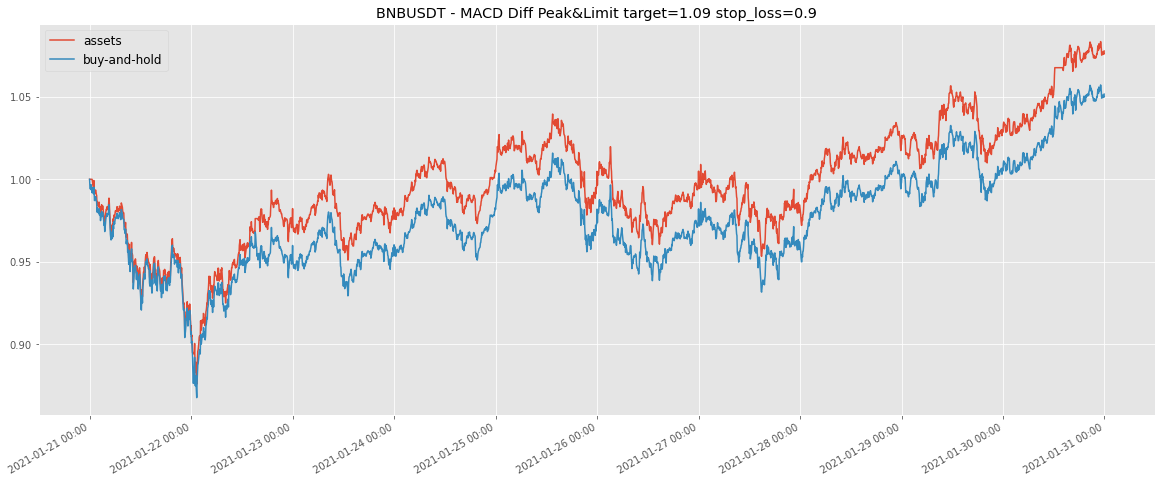

In [120]:
df_test = df_orig.iloc[12*24*20:12*24*30]

heat, xs, ys = optimise(df_test, run_id)    
display_whole(heat)

build_heatmap(heat, run_id, xs, ys)

best_target, best_stop_loss, _, _, = heat.sort_values(by='stake', ascending=False).iloc[0]

_, _, df_strategy = compute_macd_diff_peak_and_limit(
    df_test, best_target, best_stop_loss, verbose=False, plot_chart=True)

### 1 Jan to 11 Jan

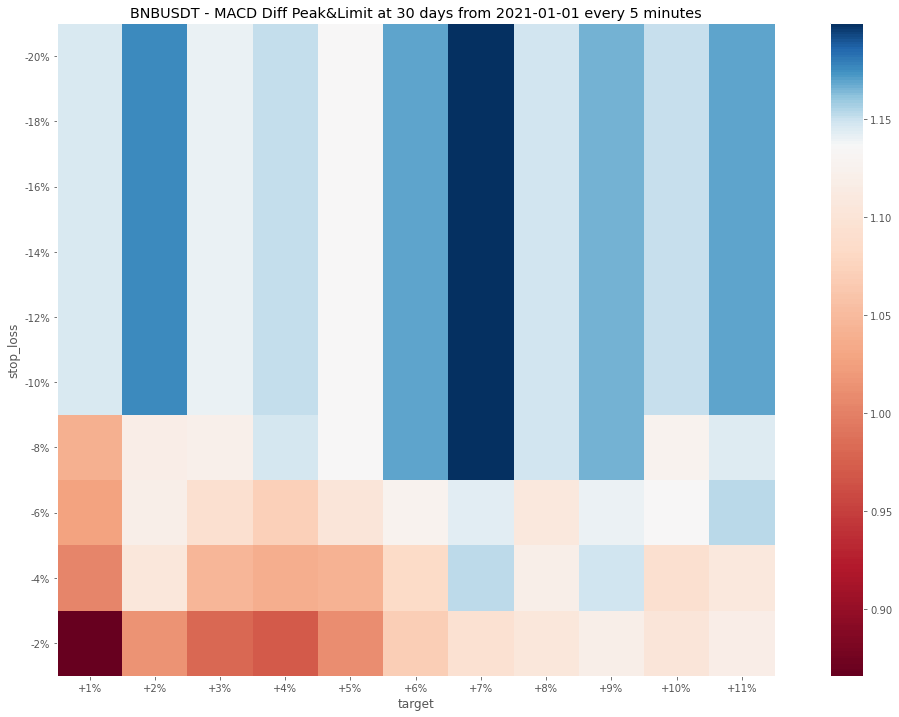

### 11 Jan to 21 Jan

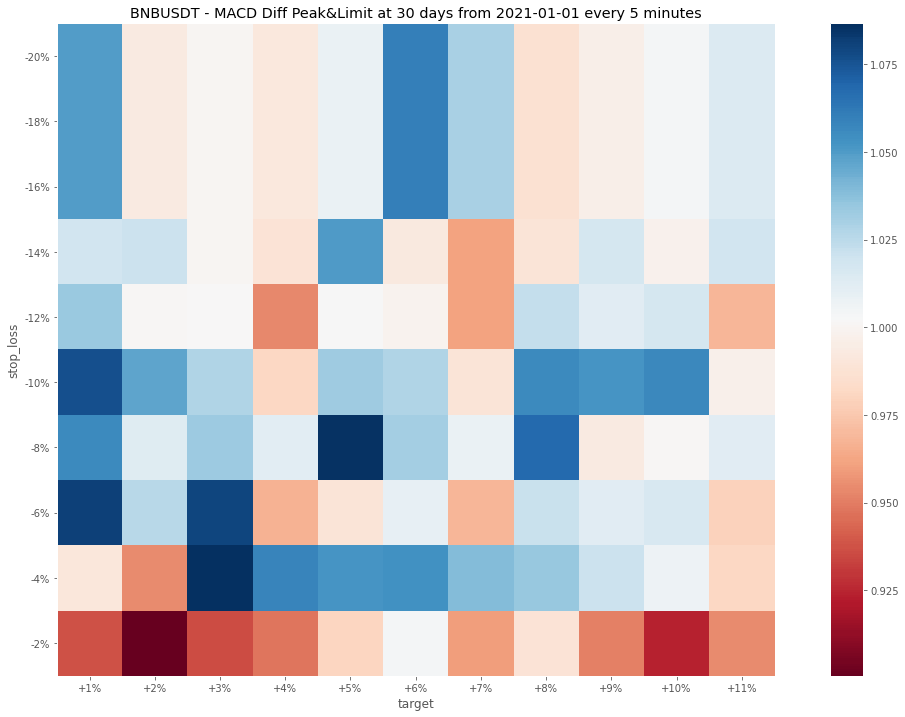

### 21 Jan to 31 Jan

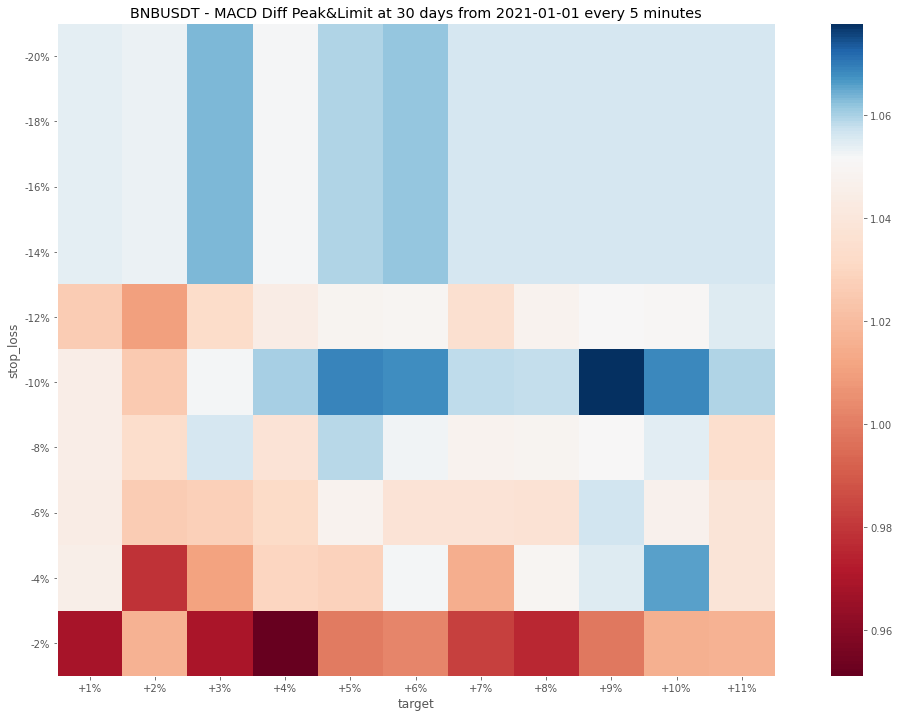